# Score Transcriptions with IPA and no IPA
### Install python packages

In [1]:
!/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip
!pip install Unidecode
!pip install python-Levenshtein
!pip install seaborn

  Using cached pip-21.0.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.3.3
    Uninstalling pip-20.3.3:
      Successfully uninstalled pip-20.3.3
     |████████████████████████████████| 241 kB 23.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 1.9 MB/s  eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp36-cp36m-linux_x86_64.whl size=155936 sha256=9662bfae1bbb155e8bf94996a8fb9fa1d5f940f881aced08df5dd420879f429a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4a/a4/bf/d761b0899395c75fa76d003d607b3869ee47f5035b8afc30a2
Successfully built python-Levenshtein


# Import Pyhthon Packages

In [2]:
import json
import pandas as pd
from io import StringIO
import boto3
import sys, os
from datetime import date, timedelta, datetime, timezone
import time 
import numpy as np
import random
import tarfile
import unidecode as uni
import re
import Levenshtein as lv
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions

### Function to get file name from S3 buckets

In [3]:
def get_all_s3_objects(s3, **base_kwargs):
    ###
    #   Function to amplify the limit of AWS results to 1000+
    ###
    continuation_token = None
    while True:
        list_kwargs = dict(MaxKeys=1000, **base_kwargs)
        if continuation_token:
            list_kwargs['ContinuationToken'] = continuation_token
        response = s3.list_objects_v2(**list_kwargs)
        yield from response.get('Contents', [])
        if not response.get('IsTruncated'):  # At the end of the list?
            break
        continuation_token = response.get('NextContinuationToken')

def get_folder_list(bucket='awstranscribe-tests', key='transcribeOutputs/Files'):
    ###
    #  Get the name of the files in a bucket. While bucket is the AWS S3 Bucket and key is the folder inside that bucket
    # it defaults to transcribeOutputs/Files
    ###
    s3 = boto3.client('s3')
    data_loc = []
    for obj in get_all_s3_objects(s3, Bucket=bucket, Prefix=key):
        names = 's3://{}/{}'.format(bucket, obj['Key'])
        data_loc.append(names)
    return data_loc

### Function to create a .csv file from a Pandas DataFrame
Creates a file into a definded AWS S3 folder

In [4]:
def to_file(df, file_name=date.today(), key='transcribeOutputs/proc_files/'):
    today = date.today()
    csv_buffer = StringIO()
    data_frame = df
    data_frame.to_csv(csv_buffer, decimal='.', sep=',', encoding='utf-8', index=False, header=None)
    s3_resource = boto3.resource('s3')
    s3_resource.Object('awstranscribe-tests', f'{key}{file_name}.csv').put(Body=csv_buffer.getvalue()) ## CHANGE temp_Mail for Mails
    
    return f'Saved as file: awstranscribe-tests/{key}{file_name}.csv'

### Function to neutralize words
Remove accent characters and lowercase the words

In [5]:
def neutralize(a_string):
    a_string = uni.unidecode(a_string)
    a_string = re.sub('[?!@#$.,]', '', a_string)
    return a_string.lower()

### function that calculates percentage of similarity

In [6]:
def similarity_score(string_real, string_model, extra_info=False):
    # cut strings to bag of words
    words_real = neutralize(string_real).split(' ')
    count = 0
    error_words = []
    for word in words_real:
        # search word in string_model
        if word in neutralize(string_model):
            count = count + 1
        else:
            error_words.append(word)

    score = count / len(words_real)
    if extra_info:
        return score, error_words
    
    return score

### Function that calculates the percentage of similarity words usaing DataFrames

In [7]:
def similarity_score_dataframes(_df_real, _df_model):
    score_list = []

    for a_file, a_string in zip(_df_model['file'], _df_model['transcript']):
        # first, we search for file in real
        real_str = _df_real[_df_real['file']==a_file]['transcript']

        # files should be 1:1, if not, we riot
        if len(real_str) != 1:
            AttributeError('Dude files are not 1:1 in ' + a_file)

        # otherwise let's continue calculating the score
        #print(real_str.array)
        score, fails = similarity_score(real_str.array[0], a_string, extra_info=True)
        score_list.append((a_file, score, fails))

    return pd.DataFrame(score_list, columns=['file', 'score', 'failed_words'])


### Read JSON from transcribe output

In [8]:
def extract_transcript(data_location):
    data_loc = get_folder_list(key=data_location)
    container = []
    for file in data_loc[1:]:
        data = pd.read_json(file)
        fname = os.path.basename(file)
        results = data['results'].get('transcripts')[0].get('transcript')
        tp = (fname, results)
        container.append(tp)
    df_transcripts = pd.DataFrame(container, columns = ['fname', 'transcript'])
    return df_transcripts

raw = extract_transcript('levenshteinTests/RAW/')
ipa = extract_transcript('levenshteinTests/IPA/')


In [9]:
def lv_score(a_series, b_series):
    metric = 0
    m_list = []
    for a_string, b_string in zip(a_series, b_series):
        a_string = neutralize(a_string)
        b_string = neutralize(b_string)
        metric = lv.distance(a_string, b_string) / len(a_string)
        m_list.append(1 - metric)
    return m_list

def average(lst):
    return sum(lst) / len(lst)
    

1.8067797879743046


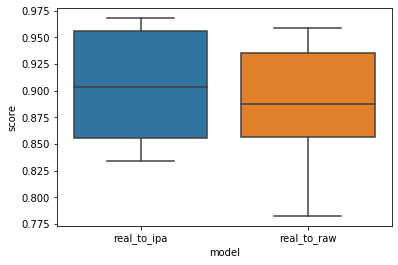

1

In [14]:
for word in get_folder_list(key='levenshteinTests/consolidados/')[1:]:
    if 'ipa' in word:
        ipa_words = pd.read_csv(word, names=['file', 'transcript'])
    if 'raw' in word:
        raw_words = pd.read_csv(word, names=['file', 'transcript'])
    if 'real' in word: 
        real_words = pd.read_csv(word, names=['transcript'])

ipa_words = ipa_words['transcript']
raw_words = raw_words['transcript']
real_words = real_words.transcript.squeeze()

real_to_ipa = lv_score(real_words, ipa_words)
real_to_raw = lv_score(real_words, raw_words)
ipa_to_raw = lv_score(ipa_words, raw_words)

ipa_tuple = [('real_to_ipa', a_score) for a_score in real_to_ipa]
raw_tuple = [('real_to_raw', a_score) for a_score in real_to_raw]

print(((average(real_to_ipa) - average(real_to_raw)) / average(real_to_raw) ) * 100)

df =  pd.DataFrame(ipa_tuple + raw_tuple, columns = ['model', 'score'])

sns.boxplot(data=df, x='model', y='score')
plt.show()

lv.distance('aaa', 'a aa')

In [11]:
metrica = 0
for ipa_word, raw_word in zip(ipa_words, raw_words):
    ipa = neutralize(ipa_word)
    raw = neutralize(raw_word)
    metrica = lv.distance(ipa, raw) / len(ipa)
    print(1 - metrica)

0.934640522875817
0.9694019471488178
0.9305555555555556
0.9934640522875817
0.941747572815534
0.968789013732834
0.9757033248081841
0.9934102141680395
0.9382022471910112
0.9870689655172413


# Testing executions

In [12]:
df_real = get_folder_list(key='transcribeOutputs/proc_files/IPA')
df_model = get_folder_list(key='transcribeOutputs/proc_files/no_IPA')

for df_real_ in df_real[1:]:
    df_real_1 = pd.read_csv(df_real_, names=['file', 'transcript'])

for df_model_ in df_model[1:]:
    df_model_1 = pd.read_csv(df_model_, names=['file', 'transcript'])

#scr_list = similarity_score_dataframes(df_real_1, df_model_1)
#print("Mean: ", scr_list['score'].mean())
#print(scr_list.head()) 

words_real = df_real_1['transcript']
words_test = df_model_1['transcript']

metrica = 0
for word_real, word_test in zip(words_real, words_test):
    good = neutralize(word_real)
    bad = neutralize(word_test)
    metrica = lv.distance(good, bad)  / len(good)
print(1 - metrica)
#to_file(scr_list, file_name='Testing01')

0.9814814814814815


In [13]:
nice = 'alo? Buenas tardes. Habló con Don Jorge. Cadenas, kilos favor Diga sí o no. alo? No se debemos. Disculpe. Pero usted, Don Jorge Cadenas, quiero'
bad = 'a lo buenas tardes. Habló con Don Jorge. Cadenas, kilos Favor, Diga sí o no. a No se debemos. Disculpe. Pero usted, Don Jorge Cadenas, quiero'
nice = neutralize(nice)
bad = neutralize(bad)

print(nice)
print(bad)
## Lev / lawrgo de palabra  
print(len(nice))
metrica = lv.distance(nice, bad)  / len(nice)
print(1 - metrica)
lv.distance('aaa', 'aaa')   / len('aaa')

alo buenas tardes hablo con don jorge cadenas kilos favor diga si o no alo no se debemos disculpe pero usted don jorge cadenas quiero
a lo buenas tardes hablo con don jorge cadenas kilos favor diga si o no a no se debemos disculpe pero usted don jorge cadenas quiero
133
0.9774436090225564


0.0

In [ ]:

'''
plt.style.use('ggplot')
x = ['IPA', 'RAW', 'REAL']

score_list = [real_to_ipa, real_to_raw, ipa_to_raw]

x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, score_list, color='blue')
plt.xlabel("Traduccion")
plt.ylabel("Score")
plt.title("This is only a test")

plt.xticks(x_pos, x)
plt.show()


metrica = 0
for ipa_word, raw_word in zip(ipa_words, raw_words):
    ipa = neutralize(ipa_word)
    raw = neutralize(raw_word)
    metrica = lv.distance(ipa, raw) / len(ipa)
print(1 - metrica)
'''